# LGBM

>>> Loading Parquet Data...
>>> Resampling to 15min bars...
>>> Creating Delta Target...
Data Prepared. Train: 25294, Val: 2810, Test: 7026
>>> Tuning Hyperparameters...
Best Params: {'learning_rate': 0.09211496547883116, 'num_leaves': 49, 'max_depth': 3, 'min_child_samples': 25, 'reg_alpha': 1.8259698841570338e-08, 'reg_lambda': 0.0004067597927605321, 'colsample_bytree': 0.6198614839861215}
>>> Training Final Model...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[298]	valid_0's l2: 12.4518

=== RESULTS ===
Model RMSE:   7.775994
Baseline RMSE:8.979441
Improvement:  13.40%
Directional Accuracy: 61.72%


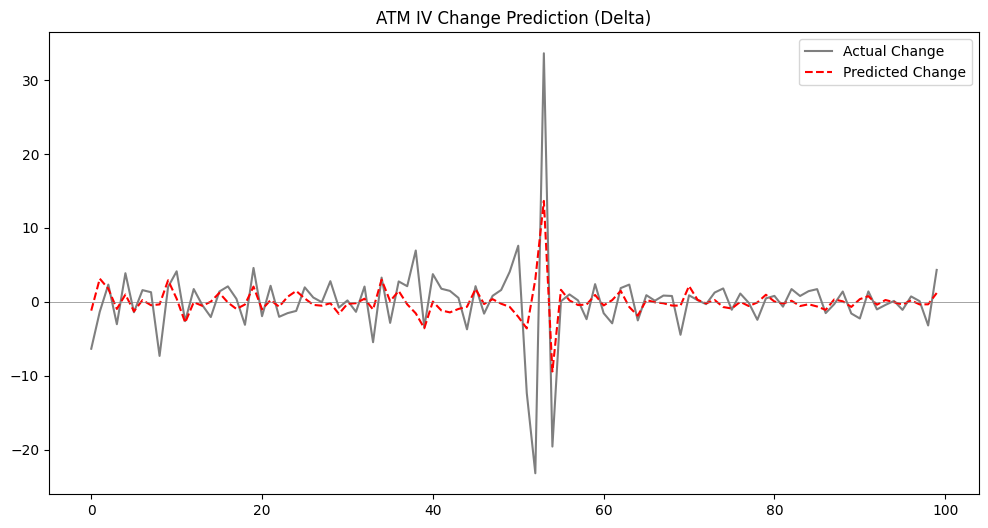

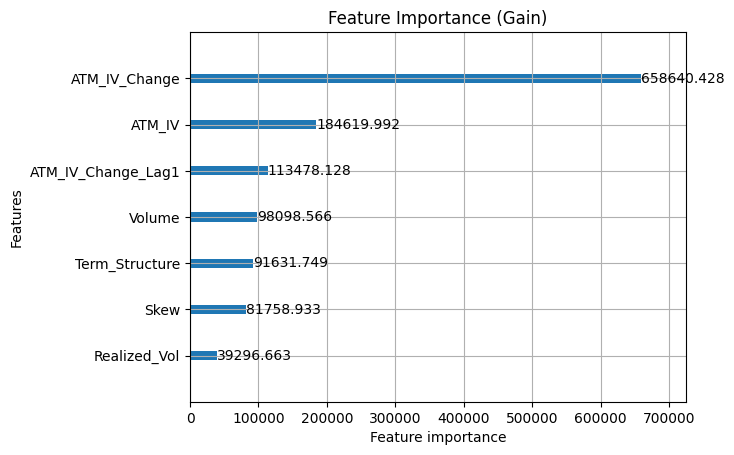

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import TimeSeriesSplit

# ==========================================
# 1. CONFIGURATION
# ==========================================
TIME_WINDOW = "15min"
FILE_PATH   = "../data/derivative_data_2025.parquet"
N_TRIALS    = 20  # Optimization trials

# ==========================================
# 2. DATA LOADING
# ==========================================
print(">>> Loading Parquet Data...")
df = pd.read_parquet(FILE_PATH, engine="pyarrow")

if pd.api.types.is_numeric_dtype(df["timestamp"]):
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
else:
    df["timestamp"] = pd.to_datetime(df["timestamp"])

# Filter BTC
df = df[df["instrument_name"].str.contains("BTC")]

# Parse Instruments
split_names = df["instrument_name"].str.split("-", expand=True)
df["Expiry_Str"] = split_names[1]
df["Strike"]     = split_names[2].astype(float)
df["Type"]       = split_names[3]
df["Expiry"]     = pd.to_datetime(df["Expiry_Str"], format="%d%b%y", errors="coerce")
df["days_to_expiry"] = (df["Expiry"] - df["timestamp"]).dt.total_seconds() / (24 * 3600)
df["moneyness"]      = df["index_price"] / df["Strike"]
df["iv"]             = pd.to_numeric(df["iv"], errors="coerce")
df = df[df["iv"] > 0]

# ==========================================
# 3. FEATURE ENGINEERING
# ==========================================
print(f">>> Resampling to {TIME_WINDOW} bars...")

def calculate_features(sub_df):
    if sub_df.empty:
        return None
    stats = {}

    # --- IV SURFACE ---
    atm_mask = sub_df["moneyness"].between(0.98, 1.02)
    if atm_mask.any():
        stats["ATM_IV"] = sub_df.loc[atm_mask, "iv"].mean()
    else:
        stats["ATM_IV"] = sub_df["iv"].mean()

    # Skew
    put_iv  = sub_df.loc[sub_df["Type"] == "P", "iv"].mean()
    call_iv = sub_df.loc[sub_df["Type"] == "C", "iv"].mean()
    put_iv  = put_iv  if pd.notna(put_iv)  else stats["ATM_IV"]
    call_iv = call_iv if pd.notna(call_iv) else stats["ATM_IV"]
    stats["Skew"] = put_iv - call_iv

    # Term Structure
    near_mask = sub_df["days_to_expiry"] <= 10
    far_mask  = sub_df["days_to_expiry"] > 10
    iv_near = sub_df.loc[near_mask, "iv"].mean()
    iv_far  = sub_df.loc[far_mask,  "iv"].mean()
    iv_near = iv_near if (pd.notna(iv_near) and iv_near > 0) else stats["ATM_IV"]
    iv_far  = iv_far  if pd.notna(iv_far) else stats["ATM_IV"]
    stats["Term_Structure"] = iv_far / iv_near

    # --- MARKET DATA ---
    stats["Close_Price"] = sub_df["index_price"].iloc[-1]
    stats["Volume"]      = sub_df["amount"].sum()

    return pd.Series(stats)

df_grouped = df.set_index("timestamp").resample(TIME_WINDOW).apply(calculate_features)
df_grouped = df_grouped.ffill()

# ==========================================
# 4. TARGET CREATION (DELTA PREDICTION)
# ==========================================
print(">>> Creating Delta Target...")

df_grouped["ATM_IV_Change"]      = df_grouped["ATM_IV"].diff()
df_grouped["ATM_IV_Change_Lag1"] = df_grouped["ATM_IV_Change"].shift(1)

df_grouped["returns"]      = np.log(df_grouped["Close_Price"] / df_grouped["Close_Price"].shift(1))
df_grouped["Realized_Vol"] = df_grouped["returns"].shift(1).rolling(window=4).std()

# Target: Future Change in IV
df_grouped["Target_Delta"] = df_grouped["ATM_IV"].shift(-1) - df_grouped["ATM_IV"]

# Clean Data
model_data = df_grouped.dropna()

# Features
feature_cols = ["ATM_IV", "Skew", "Term_Structure", "Realized_Vol",
                "Volume", "ATM_IV_Change", "ATM_IV_Change_Lag1"]
X = model_data[feature_cols]
y = model_data["Target_Delta"]

# ==========================================
# 4.5 SPLIT (FIXED: TRAIN/VAL/TEST CHRONOLOGICAL)
#   - Test is untouched for early stopping and tuning
#   - Val is the last chunk of the training portion
# ==========================================
split_idx = int(len(model_data) * 0.8)  # test starts here

X_train_full = X.iloc[:split_idx]
y_train_full = y.iloc[:split_idx]
X_test       = X.iloc[split_idx:]
y_test       = y.iloc[split_idx:]

# make a chronological validation slice from the END of train_full
VAL_FRAC = 0.10
val_size  = max(1, int(len(X_train_full) * VAL_FRAC))
val_start = len(X_train_full) - val_size

X_train = X_train_full.iloc[:val_start]
y_train = y_train_full.iloc[:val_start]
X_val   = X_train_full.iloc[val_start:]
y_val   = y_train_full.iloc[val_start:]

print(f"Data Prepared. Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# ==========================================
# 5. HYPERPARAMETER TUNING (NO TEST LEAKAGE)
#   - CV happens ONLY inside X_train_full (train+val block)
# ==========================================
print(">>> Tuning Hyperparameters...")

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }

    tscv = TimeSeriesSplit(n_splits=3)
    scores = []

    for tr_idx, va_idx in tscv.split(X_train_full):
        x_tr, x_va = X_train_full.iloc[tr_idx], X_train_full.iloc[va_idx]
        y_tr, y_va = y_train_full.iloc[tr_idx], y_train_full.iloc[va_idx]

        model = lgb.LGBMRegressor(**params, n_estimators=500)
        model.fit(
            x_tr, y_tr,
            eval_set=[(x_va, y_va)],
            callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)]
        )
        preds = model.predict(x_va)
        scores.append(np.sqrt(mean_squared_error(y_va, preds)))

    return float(np.mean(scores))

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS)

print(f"Best Params: {study.best_params}")

# ==========================================
# 6. FINAL TRAINING & EVALUATION (FIXED)
#   - Early stop on VAL (not TEST)
#   - Evaluate once on TEST (untouched)
# ==========================================
print(">>> Training Final Model...")

final_model = lgb.LGBMRegressor(**study.best_params, n_estimators=1000)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# Test untouched until now
y_pred = final_model.predict(X_test)

# --- METRICS ---
final_rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))

# Naive baseline: predict 0 change
naive_preds = np.zeros_like(y_test)
naive_rmse  = float(np.sqrt(mean_squared_error(y_test, naive_preds)))

# Directional accuracy (sign)
pred_signs   = np.sign(y_pred)
actual_signs = np.sign(y_test)
valid_idx = actual_signs != 0
dir_acc = accuracy_score(actual_signs[valid_idx], pred_signs[valid_idx])

print("\n=== RESULTS ===")
print(f"Model RMSE:   {final_rmse:.6f}")
print(f"Baseline RMSE:{naive_rmse:.6f}")
print(f"Improvement:  {((naive_rmse - final_rmse)/naive_rmse)*100:.2f}%")
print(f"Directional Accuracy: {dir_acc*100:.2f}%")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label="Actual Change", color="black", alpha=0.5)
plt.plot(y_pred[:100], label="Predicted Change", color="red", linestyle="--")
plt.axhline(0, color="grey", lw=0.5)
plt.title("ATM IV Change Prediction (Delta)")
plt.legend()
plt.show()

lgb.plot_importance(final_model, importance_type="gain", title="Feature Importance (Gain)")
plt.show()


# CatBoost

>>> Loading Parquet Data...
>>> Resampling to 15min bars...
>>> Creating Delta Target...
Data Prepared. Train: 25294, Val: 2810, Test: 7026
>>> Tuning CatBoost Hyperparameters...
Best Params: {'depth': 4, 'learning_rate': 0.09567448387228686, 'l2_leaf_reg': 0.07134744860451674, 'subsample': 0.5306324767875488, 'min_data_in_leaf': 66}
>>> Training Final CatBoost Model...
0:	learn: 4.9514450	test: 3.9870977	best: 3.9870977 (0)	total: 1.45ms	remaining: 2.17s
100:	learn: 4.0912050	test: 3.5187216	best: 3.5184217 (94)	total: 127ms	remaining: 1.75s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.512211082
bestIteration = 144

Shrink model to first 145 iterations.

=== CATBOOST RESULTS ===
Model RMSE:   7.682803
Baseline RMSE:8.979441
Improvement:  14.44%
Directional Accuracy: 61.72%


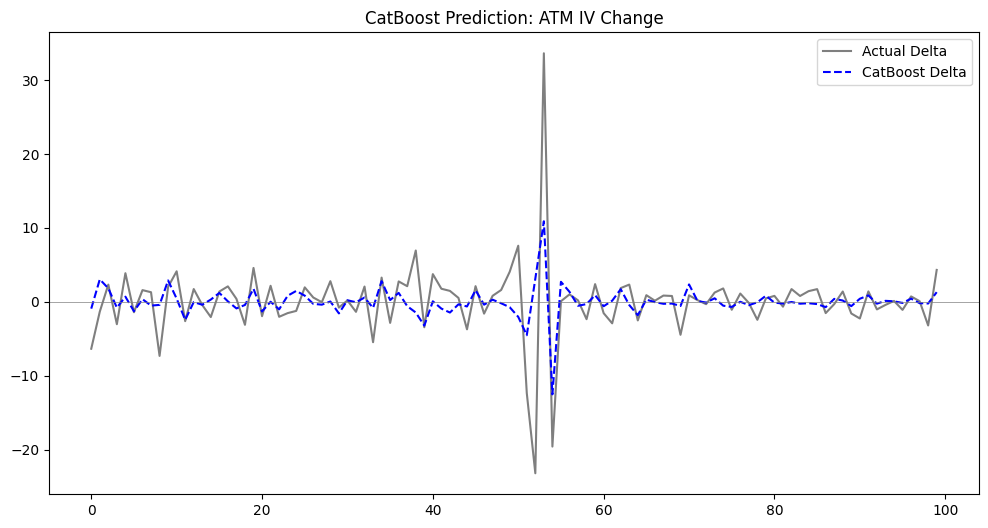

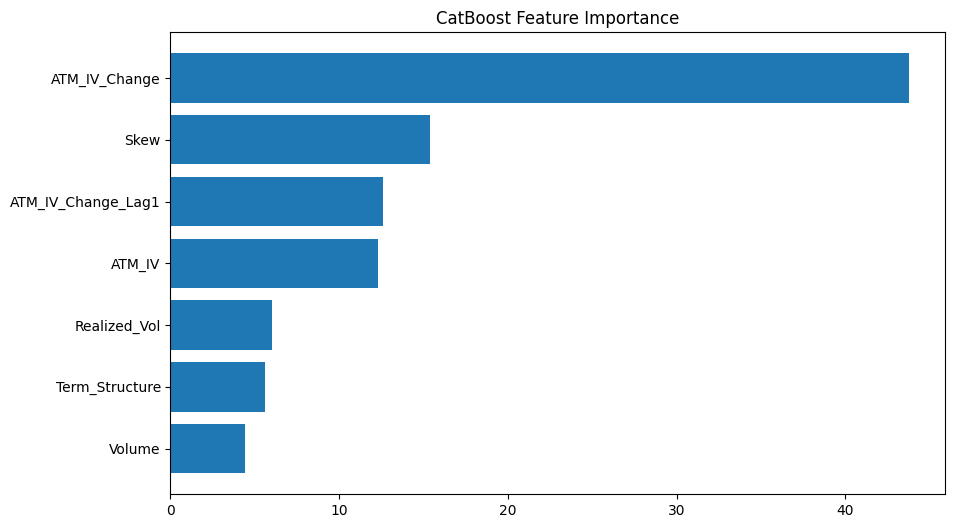

In [3]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import TimeSeriesSplit

# ==========================================
# 1. CONFIGURATION
# ==========================================
TIME_WINDOW  = "15min"
FILE_PATH    = "../data/derivative_data_2025.parquet"
N_TRIALS     = 20
RANDOM_SEED  = 42
VAL_FRAC     = 0.10  # validation slice taken from end of training block

# ==========================================
# 2. DATA LOADING
# ==========================================
print(">>> Loading Parquet Data...")
df = pd.read_parquet(FILE_PATH, engine="pyarrow")

if pd.api.types.is_numeric_dtype(df["timestamp"]):
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
else:
    df["timestamp"] = pd.to_datetime(df["timestamp"])

# Filter BTC
df = df[df["instrument_name"].str.contains("BTC")]

# Parse Instruments
split_names = df["instrument_name"].str.split("-", expand=True)
df["Expiry_Str"] = split_names[1]
df["Strike"]     = split_names[2].astype(float)
df["Type"]       = split_names[3]
df["Expiry"]     = pd.to_datetime(df["Expiry_Str"], format="%d%b%y", errors="coerce")
df["days_to_expiry"] = (df["Expiry"] - df["timestamp"]).dt.total_seconds() / (24 * 3600)
df["moneyness"]      = df["index_price"] / df["Strike"]
df["iv"]             = pd.to_numeric(df["iv"], errors="coerce")
df = df[df["iv"] > 0]

# ==========================================
# 3. FEATURE ENGINEERING
# ==========================================
print(f">>> Resampling to {TIME_WINDOW} bars...")

def calculate_features(sub_df):
    if sub_df.empty:
        return None
    stats = {}

    # --- IV SURFACE ---
    atm_mask = sub_df["moneyness"].between(0.98, 1.02)
    if atm_mask.any():
        stats["ATM_IV"] = sub_df.loc[atm_mask, "iv"].mean()
    else:
        stats["ATM_IV"] = sub_df["iv"].mean()

    # Skew
    put_iv  = sub_df.loc[sub_df["Type"] == "P", "iv"].mean()
    call_iv = sub_df.loc[sub_df["Type"] == "C", "iv"].mean()
    put_iv  = put_iv  if pd.notna(put_iv)  else stats["ATM_IV"]
    call_iv = call_iv if pd.notna(call_iv) else stats["ATM_IV"]
    stats["Skew"] = put_iv - call_iv

    # Term Structure
    near_mask = sub_df["days_to_expiry"] <= 10
    far_mask  = sub_df["days_to_expiry"] > 10
    iv_near = sub_df.loc[near_mask, "iv"].mean()
    iv_far  = sub_df.loc[far_mask,  "iv"].mean()
    iv_near = iv_near if (pd.notna(iv_near) and iv_near > 0) else stats["ATM_IV"]
    iv_far  = iv_far  if pd.notna(iv_far) else stats["ATM_IV"]
    stats["Term_Structure"] = iv_far / iv_near

    # --- MARKET DATA ---
    stats["Close_Price"] = sub_df["index_price"].iloc[-1]
    stats["Volume"]      = sub_df["amount"].sum()

    return pd.Series(stats)

df_grouped = df.set_index("timestamp").resample(TIME_WINDOW).apply(calculate_features)
df_grouped = df_grouped.ffill()

# ==========================================
# 4. TARGET CREATION (DELTA)
# ==========================================
print(">>> Creating Delta Target...")

df_grouped["ATM_IV_Change"]      = df_grouped["ATM_IV"].diff()
df_grouped["ATM_IV_Change_Lag1"] = df_grouped["ATM_IV_Change"].shift(1)
df_grouped["returns"]            = np.log(df_grouped["Close_Price"] / df_grouped["Close_Price"].shift(1))
df_grouped["Realized_Vol"]       = df_grouped["returns"].shift(1).rolling(window=4).std()

df_grouped["Target_Delta"] = df_grouped["ATM_IV"].shift(-1) - df_grouped["ATM_IV"]

model_data = df_grouped.dropna()

feature_cols = ["ATM_IV", "Skew", "Term_Structure", "Realized_Vol",
                "Volume", "ATM_IV_Change", "ATM_IV_Change_Lag1"]

X = model_data[feature_cols]
y = model_data["Target_Delta"]

# ==========================================
# 4.5 SPLIT (FIXED: TRAIN/VAL/TEST CHRONOLOGICAL)
#   - Test untouched until final evaluation
# ==========================================
split_idx = int(len(model_data) * 0.8)  # test starts here

X_train_full = X.iloc[:split_idx]
y_train_full = y.iloc[:split_idx]
X_test       = X.iloc[split_idx:]
y_test       = y.iloc[split_idx:]

val_size  = max(1, int(len(X_train_full) * VAL_FRAC))
val_start = len(X_train_full) - val_size

X_train = X_train_full.iloc[:val_start]
y_train = y_train_full.iloc[:val_start]
X_val   = X_train_full.iloc[val_start:]
y_val   = y_train_full.iloc[val_start:]

print(f"Data Prepared. Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# ==========================================
# 5. HYPERPARAMETER TUNING (CATBOOST)
#   - CV runs ONLY inside X_train_full (train+val block)
# ==========================================
print(">>> Tuning CatBoost Hyperparameters...")

def objective(trial):
    params = {
        "loss_function": "RMSE",
        "verbose": False,
        "random_seed": RANDOM_SEED,
        "iterations": 1000,
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
    }

    tscv = TimeSeriesSplit(n_splits=3)
    scores = []

    for tr_idx, va_idx in tscv.split(X_train_full):
        x_tr, x_va = X_train_full.iloc[tr_idx], X_train_full.iloc[va_idx]
        y_tr, y_va = y_train_full.iloc[tr_idx], y_train_full.iloc[va_idx]

        model = CatBoostRegressor(**params)
        model.fit(
            x_tr, y_tr,
            eval_set=(x_va, y_va),
            early_stopping_rounds=20,
            verbose=False
        )

        preds = model.predict(x_va)
        scores.append(np.sqrt(mean_squared_error(y_va, preds)))

    return float(np.mean(scores))

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS)

print(f"Best Params: {study.best_params}")

# ==========================================
# 6. FINAL TRAINING & EVALUATION (FIXED)
#   - Early stop on VAL (not TEST)
#   - Evaluate once on TEST (untouched)
# ==========================================
print(">>> Training Final CatBoost Model...")

best_params = dict(study.best_params)
best_params["iterations"]    = 1500
best_params["loss_function"] = "RMSE"
best_params["random_seed"]   = RANDOM_SEED
best_params["verbose"]       = False

final_model = CatBoostRegressor(**best_params)
final_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=50,
    verbose=100
)

# Test untouched until now
y_pred = final_model.predict(X_test)

# --- METRICS ---
final_rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
naive_rmse = float(np.sqrt(mean_squared_error(y_test, np.zeros_like(y_test))))

pred_signs   = np.sign(y_pred)
actual_signs = np.sign(y_test)
valid_idx = actual_signs != 0
dir_acc = accuracy_score(actual_signs[valid_idx], pred_signs[valid_idx])

print("\n=== CATBOOST RESULTS ===")
print(f"Model RMSE:   {final_rmse:.6f}")
print(f"Baseline RMSE:{naive_rmse:.6f}")
print(f"Improvement:  {((naive_rmse - final_rmse)/naive_rmse)*100:.2f}%")
print(f"Directional Accuracy: {dir_acc*100:.2f}%")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label="Actual Delta", color="black", alpha=0.5)
plt.plot(y_pred[:100], label="CatBoost Delta", color="blue", linestyle="--")
plt.axhline(0, color="grey", lw=0.5)
plt.title("CatBoost Prediction: ATM IV Change")
plt.legend()
plt.show()

# Feature Importance
feature_importance = final_model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(feature_cols)[sorted_idx])
plt.title("CatBoost Feature Importance")
plt.show()
